In [2]:
import numpy as np
from scipy.sparse import lil_matrix, csc_matrix, csr_matrix
from scipy.sparse.linalg import expm_multiply
from scipy.linalg import eigh

import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'serif','serif':['helvetica'],'size': 16})
rc('text', usetex=True)

import jax
from jax import jit
import jax.numpy as jnp
from jax import grad, jit, vmap, jacfwd, jacrev, vjp
from jax.scipy.linalg import expm
from jax.lax import fori_loop
jax.config.update("jax_enable_x64", True)

## Molecule setup

In [3]:
def get_toy_example(J,g):
    JAB = g*jnp.array([[1,1]])
    JB = J*jnp.array([[0,1],[1,0]])
    return JAB, JB

def encode_params(JAB, JBB, Delta):
    nA = JAB.shape[0]
    nB = JAB.shape[1]
    assert JBB.shape[0]==nB
    assert JBB.shape[1]==nB
    assert len(Delta) == nB

    dim = int(nA*nB+nB*(nB+1)/2)
    theta = np.zeros([dim])
    JAB = np.reshape(JAB, [nA, nB])
    theta[:nA*nB] = JAB
    counter = 0
    for i in range(nB):
        for j in range(i+1,nB):
            theta[nA*nB+counter] = JBB[i,j]
            counter += 1
    theta[nA*nB+counter:] = Delta
    return theta

def get_haar_random_state(dimH, m):
    np.random.seed(m)
    psi0 = np.random.normal(0,1,dimH) + 1j * np.random.normal(0,1,dimH)
    return psi0/np.sqrt(np.dot(psi0.conj(), psi0))


### Defining the geometry

In [4]:
# start with a simple 3 spin system
nA = 1
nB = 2

# Couplings
J,g = 2,1

# Backbone
m = 0
np.random.seed(m)
Delta = np.random.standard_normal(2)

JAB, JB = get_toy_example(J,g)
theta = encode_params(JAB, JB, Delta)

# infinite temperature bath, exact dynamics
M = 2
psi0_A = jnp.ones(2)/jnp.sqrt(2)
psi0_list = [np.kron(psi0_A, get_haar_random_state(2**nB, m)) for m in range(M)]



# Jaxed Autodiffing

### Helper functions

In [5]:
# Helper Functions

def int2array(states, L):
    # states is (N, )
    N = states.shape[0]
    toret = jnp.zeros((N, L)).astype('int')
    for i in range(L):
        toret = toret.at[:,-1-1].set(states % 2)
        #toret[:, -i-1] = states % 2
        states = states // 2
    return toret

def array2int(states):
    # states is (N, L)
    N = states.shape[0]
    L = states.shape[1]

    toret = jnp.zeros(N).astype('int')
    for i in range(L):
        toret += 2**i * states[:, -i-1]
    return toret

def get_sec_inds(L):
    sec_inds_list = []
    basis = jnp.arange(2**L)
    ns = jnp.sum(int2array(basis,L),1) #(2**L, L)
    for a in range(L+1):
        inds = jnp.where(ns==a)[0]
        sec_inds_list.append(inds)
    return sec_inds_list

def build_hadamards(n):

    def tensor_power(A0, L):
        A = A0
        for j in range(1,L):
            A = jnp.kron(A, A0)
        return A

    Hx = jnp.array([[1,1],[1,-1]], dtype=complex)/jnp.sqrt(2)
    Hy = jnp.array([[1,-1j],[-1j,1]], dtype=complex)/jnp.sqrt(2)

    return tensor_power(Hx,n), tensor_power(Hy,n)

def right_multiply(A, B):
    return jnp.swapaxes(jnp.tensordot(A, B, axes=((1),(0))),1,2)

def decode_params(theta, nA, nB):
    JAB = theta[:nA*nB]
    JAB = jnp.reshape(JAB, [nA, nB])
    JBB = jnp.zeros([nB, nB])
    counter = 0
    for i in range(nB):
        for j in range(i+1,nB):
            JBB = JBB.at[i,j].set(theta[nA*nB+counter])
            counter+=1
    Delta = theta[nA*nB+counter:]
    return JAB, JBB, Delta

def partial_trace(psi,nA,nB):
    Psi = jnp.reshape(psi, [2**nA, 2**nB])
    return Psi @ Psi.conj().T


# def partial_trace(psi, nA, nB):
#     if len(psi.shape) == 1:
#         Psi = jnp.reshape(psi, [2**nA, 2**nB])
#         rhoA = Psi @ Psi.conj().T
#     else:
#         assert len(psi.shape) == 2
#         M = psi.shape[1]
#         Psi = jnp.reshape(psi, [2**nA, 2**nB, M])
#         rhoA = jnp.zeros([2**nA, 2**nA, M], dtype='complex128')
#         for k in range(M):
#             rhoA[:,:,k] = Psi[:,:,k] @ Psi[:,:,k].conj().T
#     return rhoA

def get_trotter_energies(JAB, JBB, Delta):
    g = jnp.array([1,1,-2])
    nA = JAB.shape[0]
    nB = JBB.shape[0]
    n = nA+nB
    
    indsA = jnp.arange(nA)
    indsB = jnp.arange(nA, n)
    JAB_pad = jnp.zeros([n, n])
    JAB_pad = JAB_pad.at[indsA[:,jnp.newaxis],indsB[jnp.newaxis,:]].set(JAB)
    JAB_pad = JAB_pad.at[indsB[:,jnp.newaxis],indsA[jnp.newaxis,:]].set(JAB.T)

    # Sensing Hamiltonian
    epAB = jnp.zeros([3, 2**n])
    z = 2*int2array(jnp.arange(2**n),n)-1 # (2**n, n)
    for mu in range(3):
        epAB = epAB.at[mu,:].set(g[mu]*jnp.diag(z @ JAB_pad @ z.T) / 4)

    # Molecule Hamiltonian
    epBB = jnp.zeros([3, 2**nB])
    z = 2*int2array(jnp.arange(2**nB), nB)-1 # (2**n, n)
    for mu in range(3):
        epBB = epBB.at[mu,:].set(g[mu]*jnp.diag(z @ JBB @ z.T) / 4)
        if mu ==2:
            epBB = epBB.at[mu,:].set(z @ Delta / 2)

    return epAB, epBB


## Pure state derivatives

#### List based iteration over sampled molecule states

In [6]:
def build_evolution(hyperparams):
    nA = hyperparams['nA']
    nB = hyperparams['nB']
    n = nA + nB

    t = hyperparams['t']
    n_measure = hyperparams['n_measure']
    dt = hyperparams['dt']
    tau = hyperparams['tau']
    dtau = hyperparams['dtau']

    ts = np.arange(0, t, n_measure*dt)
    N_t = len(ts)

    N_tau = int(tau/dtau)

    reverse_sense = hyperparams['reverse_sense']
    psi0_list = hyperparams["psi0_list"] 

    Hx, Hy = build_hadamards(n)
    Hx_nB, Hy_nB = build_hadamards(nB)
    
    # any variational (input) parameters should be included in params.
    def apply_evolution(theta, args):

        # this is where the Ham params go!
        JAB, JBB, Delta = decode_params(theta, nA, nB)
        epAB, epBB = get_trotter_energies(JAB, JBB, Delta)

        DAB = jnp.exp(-1j * epAB * dtau / 2) 
        DB = jnp.exp(-1j*epBB*dt/2)
        DB = jnp.repeat(DB[:,jnp.newaxis,:], 2**nA, axis=1)

        def apply_sensing_trotter_step(t0, psi):
            psi = DAB[2,:] * psi # ZZ
            psi = Hx.conj().T @ (DAB[0,:] * (Hx @ psi)) # XX
            psi = Hy.conj().T @ (DAB[1,:]**2 * (Hy @ psi)) # YY
            psi = Hx.conj().T @ (DAB[0,:] * (Hx @ psi)) # XX
            psi = DAB[2,:] * psi # ZZ
            return psi
        
        def apply_reverse_sensing_trotter_step(t0, psi):
            psi = DAB[2,:].conj() * psi # ZZ
            psi = Hx.conj().T @ (DAB[0,:].conj() * (Hx @ psi)) # XX
            psi = Hy.conj().T @ (DAB[1,:].conj()**2 * (Hy @ psi)) # YY
            psi = Hx.conj().T @ (DAB[0,:].conj() * (Hx @ psi)) #XX
            psi = DAB[2,:].conj() * psi # ZZ
            return psi

        def apply_molecule_trotter_step(t0, psi):
            Psi = jnp.reshape(psi, [2**nA, 2**nB])
            Psi = DB[2,:,:] * Psi # ZZ
            Psi =  ((Psi @ Hx_nB.T) * DB[0,:,:]) @ Hx_nB.conj() # XX
            Psi =  ((Psi @ Hy_nB.T) * (DB[1,:,:]**2)) @ Hy_nB.conj() # YY
            Psi =  ((Psi @ Hx_nB.T) * DB[0,:,:]) @ Hx_nB.conj() # XX
            Psi = DB[2,:,:] * Psi # ZZ
            psi = jnp.ravel(Psi)
            return psi 
        
        psi_list = []
        
        for psi0 in psi0_list:
            #psi_intermediates = []
            psi1 = psi0.copy()
            
            # sense
            psi1 = fori_loop(0, N_tau, apply_sensing_trotter_step, psi1)

            # evolve
            psi_cont = jnp.zeros((N_t+1, 2**n), dtype='complex128')
            psi_cont = psi_cont.at[0,:].set(psi1)

            def evolve_molecule(t0, psi_cont):
                psi2 = psi_cont[t0,:]
                psi3 = fori_loop(0, N_tau, apply_reverse_sensing_trotter_step, psi2)
                psi2 = fori_loop(0, n_measure, apply_molecule_trotter_step, psi2)
                
                psi_cont = psi_cont.at[t0,:].set(psi3)
                psi_cont = psi_cont.at[t0+1,:].set(psi2)
                return psi_cont
            
            def evolve_molecule_noreverse(t0, psi_cont):
                psi2 = psi_cont[t0,:]
                psi2 = fori_loop(0, n_measure, apply_molecule_trotter_step, psi2)
                psi_cont = psi_cont.at[t0+1,:].set(psi2)
                return psi_cont
            if reverse_sense:
                psi_cont = fori_loop(0, N_t, evolve_molecule, psi_cont)
            else:
                psi_cont = fori_loop(0, N_t, evolve_molecule_noreverse, psi_cont)
            psi_list.append(psi_cont[:-1,:])

        return jnp.array(psi_list)
    
    return jit(apply_evolution)

In [7]:
hyperparams = {}
args = {}
hyperparams['nA'] = nA 
hyperparams['nB'] = nB 



# time evolution params
tau = 2
dtau = 1e-2
t = 10
n_measure = 2
dt = 1e-2
ts = np.arange(0,t,n_measure*dt)


hyperparams['t'] = t 
hyperparams['n_measure'] = n_measure 
hyperparams['dt'] = dt 
hyperparams['tau'] = tau 
hyperparams['dtau'] = dtau

ts = np.arange(0, t, n_measure*dt)
N_t = len(ts)
N_tau = int(tau/dtau)

hyperparams['reverse_sense'] = False

hyperparams["psi0_list"] = psi0_list

sensing_evol = build_evolution(hyperparams)

psi_grad = jacfwd(sensing_evol)
psi_grad(theta, args)
print(psi_grad(theta, args).shape)

(2, 500, 8, 5)


### Tensorized parallel computations on sampled molecule states

In [8]:
def build_evolution_vect(hyperparams):
    nA = hyperparams['nA']
    nB = hyperparams['nB']
    n = nA + nB

    t = hyperparams['t']
    n_measure = hyperparams['n_measure']
    dt = hyperparams['dt']
    tau = hyperparams['tau']
    dtau = hyperparams['dtau']

    ts = np.arange(0, t, n_measure*dt)
    N_t = len(ts)

    N_tau = int(tau/dtau)

    reverse_sense = hyperparams['reverse_sense']
    psi0 = hyperparams["psi0"] # tensor of initial sampled states , (2**n, M)
    M = psi0.shape[1]

    Hx, Hy = build_hadamards(n)
    Hx_nB, Hy_nB = build_hadamards(nB)
    
    # any variational (input) parameters should be included in params.
    def apply_evolution(theta, args):

        # this is where the Ham params go! 
        JAB, JBB, Delta = decode_params(theta, nA, nB)
        epAB, epBB = get_trotter_energies(JAB, JBB, Delta) #  (3, 2**n), (3, 2**nB)
        epAB = jnp.repeat(epAB[:,:,jnp.newaxis], M, axis=2) #  (3, 2**n, M)
        epBB = jnp.repeat(epBB[:,:,jnp.newaxis], M, axis=2) # (3, 2**nB, M)

        # evolution phases
        DAB = jnp.exp(-1j * epAB * dtau / 2) # (3, 2**n, M)
        DB = jnp.exp(-1j * epBB * dt / 2) # (3, 2**nB, M)
        DB = jnp.repeat(DB[:,jnp.newaxis,:,:], 2**nA, axis=1) # (3, 2**nA, 2**nB, M)

        def apply_sensing_trotter_step(t0, psi): # psi is always (2**n, M)
            psi = DAB[2,:,:] * psi # ZZ
            psi = Hx.conj().T @ (DAB[0,:,:] * (Hx @ psi)) # XX
            psi = Hy.conj().T @ (DAB[1,:,:]**2 * (Hy @ psi)) # YY
            psi = Hx.conj().T @ (DAB[0,:,:] * (Hx @ psi)) # XX
            psi = DAB[2,:,:] * psi # ZZ
            return psi
        
        def apply_reverse_sensing_trotter_step(t0, psi): # psi is always (2**n, M)
            psi = DAB[2,:,:].conj() * psi # ZZ
            psi = Hx.conj().T @ (DAB[0,:,:].conj() * (Hx @ psi)) # XX
            psi = Hy.conj().T @ (DAB[1,:,:].conj()**2 * (Hy @ psi)) # YY
            psi = Hx.conj().T @ (DAB[0,:,:].conj() * (Hx @ psi)) #XX
            psi = DAB[2,:,:].conj() * psi # ZZ
            return psi

        def apply_molecule_trotter_step(t0, psi): # psi is always (2**n, M)
            Psi = jnp.reshape(psi, [2**nA, 2**nB, M])
            Psi = DB[2,:,:,:] * Psi # ZZ
            Psi = right_multiply(right_multiply(Psi, Hx_nB.T) * DB[0,:,:,:], Hx_nB.conj()) # XX
            Psi = right_multiply(right_multiply(Psi, Hy_nB.T) * DB[1,:,:,:]**2, Hy_nB.conj()) # YY
            Psi = right_multiply(right_multiply(Psi, Hx_nB.T) * DB[0,:,:,:], Hx_nB.conj()) # XX
            Psi = DB[2,:,:,:] * Psi # ZZ
            psi = jnp.reshape(Psi, [2**n, M])
            return psi 
        
        psi1 = psi0.copy()
        
        # sense
        psi1 = fori_loop(0, N_tau, apply_sensing_trotter_step, psi1)

        # container for states to save
        psi_cont = jnp.zeros((N_t+1, 2**n, M), dtype='complex128')
        psi_cont = psi_cont.at[0,:,:].set(psi1)

        def evolve_molecule(t0, psi_cont):
            psi2 = psi_cont[t0,:,:]
            psi3 = fori_loop(0, N_tau, apply_reverse_sensing_trotter_step, psi2)
            psi2 = fori_loop(0, n_measure, apply_molecule_trotter_step, psi2)
            
            psi_cont = psi_cont.at[t0,:,:].set(psi3)
            psi_cont = psi_cont.at[t0+1,:,:].set(psi2)
            return psi_cont
        
        def evolve_molecule_noreverse(t0, psi_cont):
            psi2 = psi_cont[t0,:,:]
            psi2 = fori_loop(0, n_measure, apply_molecule_trotter_step, psi2)
            psi_cont = psi_cont.at[t0+1,:,:].set(psi2)
            return psi_cont
        
        if reverse_sense:
            psi_cont = fori_loop(0, N_t, evolve_molecule, psi_cont)
        else:
            psi_cont = fori_loop(0, N_t, evolve_molecule_noreverse, psi_cont)
        #psi_list.append(psi_cont[:-1,:,:])
        return psi_cont[:-1,:,:]

        
    return jit(apply_evolution)

def build_reduce(hyperparams):
    nA = hyperparams['nA']
    nB = hyperparams['nB']

    # This function takes as input a density matrix,
    # with shape (T,  ndim, M)
    def reduce(psi):
        psi = jnp.transpose(psi, [0,2,1]) # reshape this to (T, M, ndim)
        psi = jnp.reshape(psi, (psi.shape[0], psi.shape[1], 2**nA, 2**nB)) # expand ndim => (nA,nB)

        # then compute an outer product, returning (T, M, nA, nA')
        psi2 = jnp.transpose(psi, [0,1,3,2]) 
        rhos = jnp.sum(psi[:,:,:,:,jnp.newaxis] * psi2[:,:,jnp.newaxis,:,:].conj(), axis=3) 
        # finally, we will sum over M, returning (T, nA, nA')
        rho = jnp.mean(rhos, axis=1) 
        return rho
        #return jnp.stack([jnp.real(rho), jnp.imag(rho)])
    return jit(reduce)

In [9]:
hyperparams = {}
args = {}

# system size
hyperparams['nA'] = nA 
hyperparams['nB'] = nB 

# time evolution params
tau = 2
dtau = 1e-2
t = 10
n_measure = 2
dt = 1e-2
ts = np.arange(0,t,n_measure*dt)

hyperparams['t'] = t 
hyperparams['n_measure'] = n_measure 
hyperparams['dt'] = dt 
hyperparams['tau'] = tau 
hyperparams['dtau'] = dtau

ts = np.arange(0, t, n_measure*dt)
N_t = len(ts)
N_tau = int(tau/dtau)

hyperparams['reverse_sense'] = True

# initial state params
M = 100
psi0_A = jnp.ones(2)/jnp.sqrt(2)
psi0 = jnp.array([jnp.kron(psi0_A, get_haar_random_state(2**nB, m)) for m in range(M)]).T
hyperparams["psi0"] = psi0

sensing_evol = build_evolution_vect(hyperparams)

psi_grad = jacfwd(sensing_evol)
psi_grad(theta, args)
print(psi_grad(theta, args).shape)

psi = sensing_evol(theta, args)

(500, 8, 100, 5)


In [26]:
psi_grad(theta, args).shape

(500, 8, 100, 5)

In [10]:
reduce_func = build_reduce(hyperparams)

F = lambda theta, args : reduce_func(sensing_evol(theta, args))
gradF = jit(jacfwd(F))

gradF(theta, args).shape

(500, 2, 2, 5)

In [11]:
def get_reduced_states(psi):
    rhoAs = np.zeros([N_t, 2**nA, 2**nA, M], dtype='complex128')
    for m in range(M):
        for k in range(N_t):
            rhoAs[k,:,:,m] = partial_trace(psi[k,:,m], nA, nB)
    rhoAs = np.mean(rhoAs, 3)
    return rhoAs

rhoAs = get_reduced_states(psi)

In [12]:
rhoBs = reduce_func(psi)

In [18]:
rhoAs[:,0,0]

array([0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j,
       0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j,
       0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j,
       0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j,
       0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j,
       0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j,
       0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j,
       0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j,
       0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j,
       0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j,
       0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j,
       0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j,
       0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j,
       0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j,
       0.5+0.j, 0.5+

In [15]:
np.sum(np.abs(rhoAs - rhoBs))

1.1963019863185955e-13

In [38]:
# compute the fidelity
%timeit get_reduced_states(psi)

17.8 s ± 74.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [39]:
%timeit reduce_func(psi)

891 µs ± 810 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [9]:
def get_reduced_derivatives(psi, psi_grad):
    dimTheta = psi_grad.shape[3]
    drhoAs = np.zeros([N_t, 2**nA, 2**nA, dimTheta], dtype='complex128')

    #psi_grad is (N_t, 2**n, M, dimTheta)
    psi = np.reshape(psi, [N_t, 2**nA, 2**nB, M])
    print(psi.shape)
    psi_grad = np.reshape(psi_grad, [N_t, 2**nA, 2**nB, M, dimTheta])
    print(psi_grad.shape)
    print(drhoAs.shape)

    for k in range(N_t):
        for m in range(M):
            drhoAs[k, :, :, :] += np.swapaxes(np.tensordot(psi_grad[k,:,:,m,:], psi.conj()[k,:,:,m] ,axes = ((1), (1))), 1, 2) /M
        
    drhoAs = drhoAs + np.swapaxes(drhoAs.conj(), 1, 2)
    print(drhoAs.shape)
    return drhoAs

In [10]:
drhos = get_reduced_derivatives(psi, psi_grad(theta, args))

(500, 2, 4, 100)
(500, 2, 4, 100, 5)
(500, 2, 2, 5)
(500, 2, 2, 5)


### Finite temperature sampling

In [ ]:
def build_evolution_vect(hyperparams):
    nA = hyperparams['nA']
    nB = hyperparams['nB']
    n = nA + nB

    t = hyperparams['t']
    n_measure = hyperparams['n_measure']
    dt = hyperparams['dt']
    tau = hyperparams['tau']
    dtau = hyperparams['dtau']
    beta = hyperparams['beta']
    dbeta = hyperparams['dbeta']


    ts = np.arange(0, t, n_measure*dt)
    N_t = len(ts)

    N_tau = int(tau/dtau)
    N_beta = int((beta/2)/dbeta) # evolve the pure state by beta/2 to simulate finite temp!

    reverse_sense = hyperparams['reverse_sense']
    psi0 = hyperparams["psi0"] # tensor of initial sampled states , (2**n, M)
    M = psi0.shape[1]

    Hx, Hy = build_hadamards(n)
    Hx_nB, Hy_nB = build_hadamards(nB)
    
    # any variational (input) parameters should be included in params.
    def apply_evolution(theta, args):

        # this is where the Ham params go! 
        JAB, JBB, Delta = decode_params(theta, nA, nB)
        epAB, epBB = get_trotter_energies(JAB, JBB, Delta) #  (3, 2**n), (3, 2**nB)
        epAB = jnp.repeat(epAB[:,:,jnp.newaxis], M, axis=2) #  (3, 2**n, M)
        epBB = jnp.repeat(epBB[:,:,jnp.newaxis], M, axis=2) # (3, 2**nB, M)

        # time evolution phases
        DAB = jnp.exp(-1j * epAB * dtau / 2) # (3, 2**n, M)
        DB = jnp.exp(-1j * epBB * dt / 2) # (3, 2**nB, M)
        DB = jnp.repeat(DB[:,jnp.newaxis,:,:], 2**nA, axis=1) # (3, 2**nA, 2**nB, M)

        # imag time evolution attenuators
        DB_imag = jnp.exp(- epBB * dbeta / 2) # (3, 2**nB, M)
        DB_imag = jnp.repeat(DB_imag[:,jnp.newaxis,:,:], 2**nA, axis=1) # (3, 2**nA, 2**nB, M)


        def apply_molecule_trotter_step_imag(tau0, psi):
            Psi = jnp.reshape(psi, [2**nA, 2**nB, M])
            Psi = DB_imag[2,:,:,:] * Psi # ZZ
            Psi = right_multiply(right_multiply(Psi, Hx_nB.T) * DB_imag[0,:,:,:], Hx_nB.conj()) # XX
            Psi = right_multiply(right_multiply(Psi, Hy_nB.T) * DB_imag[1,:,:,:]**2, Hy_nB.conj()) # YY
            Psi = right_multiply(right_multiply(Psi, Hx_nB.T) * DB_imag[0,:,:,:], Hx_nB.conj()) # XX
            Psi = DB_imag[2,:,:,:] * Psi # ZZ
            psi = jnp.reshape(Psi, [2**n, M])
            return psi 

        def apply_sensing_trotter_step(t0, psi): # psi is always (2**n, M)
            psi = DAB[2,:,:] * psi # ZZ
            psi = Hx.conj().T @ (DAB[0,:,:] * (Hx @ psi)) # XX
            psi = Hy.conj().T @ (DAB[1,:,:]**2 * (Hy @ psi)) # YY
            psi = Hx.conj().T @ (DAB[0,:,:] * (Hx @ psi)) # XX
            psi = DAB[2,:,:] * psi # ZZ
            return psi
        
        def apply_reverse_sensing_trotter_step(t0, psi): # psi is always (2**n, M)
            psi = DAB[2,:,:].conj() * psi # ZZ
            psi = Hx.conj().T @ (DAB[0,:,:].conj() * (Hx @ psi)) # XX
            psi = Hy.conj().T @ (DAB[1,:,:].conj()**2 * (Hy @ psi)) # YY
            psi = Hx.conj().T @ (DAB[0,:,:].conj() * (Hx @ psi)) #XX
            psi = DAB[2,:,:].conj() * psi # ZZ
            return psi

        def apply_molecule_trotter_step(t0, psi): # psi is always (2**n, M)
            Psi = jnp.reshape(psi, [2**nA, 2**nB, M])
            Psi = DB[2,:,:,:] * Psi # ZZ
            Psi = right_multiply(right_multiply(Psi, Hx_nB.T) * DB[0,:,:,:], Hx_nB.conj()) # XX
            Psi = right_multiply(right_multiply(Psi, Hy_nB.T) * DB[1,:,:,:]**2, Hy_nB.conj()) # YY
            Psi = right_multiply(right_multiply(Psi, Hx_nB.T) * DB[0,:,:,:], Hx_nB.conj()) # XX
            Psi = DB[2,:,:,:] * Psi # ZZ
            psi = jnp.reshape(Psi, [2**n, M])
            return psi 
        
        psi1 = psi0.copy()
        
        # imag time evolve
        psi1 = fori_loop(0, N_beta, apply_molecule_trotter_step_imag, psi1)
        psi1 = psi1/jnp.sqrt(jnp.trace(psi1.conj().T @ psi1)) # divide by estimator of partition function
        # note that now the columns of psi1 are not normalized, yet averaging uniformly over these states yields the correct density matrix

        # sense
        psi1 = fori_loop(0, N_tau, apply_sensing_trotter_step, psi1)

        # container for states to save
        psi_cont = jnp.zeros((N_t+1, 2**n, M), dtype='complex128')
        psi_cont = psi_cont.at[0,:,:].set(psi1)

        def evolve_molecule(t0, psi_cont):
            psi2 = psi_cont[t0,:,:]
            psi3 = fori_loop(0, N_tau, apply_reverse_sensing_trotter_step, psi2)
            psi2 = fori_loop(0, n_measure, apply_molecule_trotter_step, psi2)
            
            psi_cont = psi_cont.at[t0,:,:].set(psi3)
            psi_cont = psi_cont.at[t0+1,:,:].set(psi2)
            return psi_cont
        
        def evolve_molecule_noreverse(t0, psi_cont):
            psi2 = psi_cont[t0,:,:]
            psi2 = fori_loop(0, n_measure, apply_molecule_trotter_step, psi2)
            psi_cont = psi_cont.at[t0+1,:,:].set(psi2)
            return psi_cont
        
        if reverse_sense:
            psi_cont = fori_loop(0, N_t, evolve_molecule, psi_cont)
        else:
            psi_cont = fori_loop(0, N_t, evolve_molecule_noreverse, psi_cont)
        #psi_list.append(psi_cont[:-1,:,:])
        return psi_cont[:-1,:,:]

        
    return jit(apply_evolution)

# QFI calculations

In [11]:

def vec2op(rho_vec):
    dimH = int(np.sqrt(rho_vec.shape[0]))
    return np.reshape(rho_vec, [dimH, dimH])

def op2vec(rho_op):
    return jnp.ravel(rho_op)


def get_QFIM(rhos, drhos):
    # returns both the list of SLDs and QFIM
    # assume rhos is (N_t, 2**nA, 2**nA)
    # assume drhos is (N_t, 2**nA, 2**nA, dimTheta)

    # will return the qfim, list of (dimTheta, dimTheta)
    # will return slds, list of (dimTheta, 2**nA, 2**nA)
    dimH = rhos.shape[1]
    dimTheta = drhos.shape[3]

    F_list = []
    l_list = []
    
    for k in range(N_t):
        rho = rhos[k,:,:]
        drho = drhos[k,:,:,:]
        #dimH = rho.shape[0]

    # work in vectorized formalism
        rho1 = np.kron(rho, np.eye(dimH))
        rho2 = np.kron(np.eye(dimH), rho.conj())
        S = np.linalg.pinv(rho1+rho2)
    
        F = np.zeros([dimTheta, dimTheta])
        ls = np.zeros([dimTheta, dimH, dimH], dtype='complex128')
    
        for a in range(dimTheta):
            drho_a = drho[:,:,a]
            drho_a_vec = op2vec(drho_a)
            la = S @ drho_a_vec
            ls[a,:,:] = vec2op(la)
            
            for b in range(dimTheta):
                drho_b = drho[:,:,b]
                drho_b_vec = op2vec(drho_b)
                F[a,b] = np.dot(drho_b_vec.conj(), la)

        F_list.append(F)
        l_list.append(ls)

    return F_list, l_list

F_list, l_list = get_QFIM(rhoAs, drhos)

/var/folders/nb/5gbs4wt96rs93v4n58zhrnjh0000gn/T/ipykernel_3483/1173308231.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
  F[a,b] = np.dot(drho_b_vec.conj(), la)


In [63]:
theta

array([1.        , 1.        , 2.        , 1.76405235, 0.40015721])

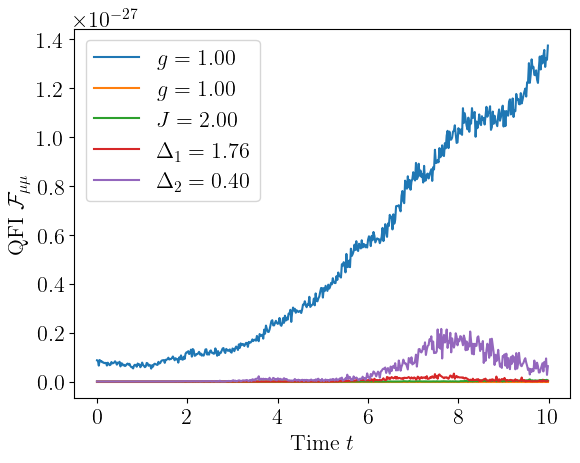

In [17]:
labels = [r'$g=%1.2f$'%theta[0],r'$g=%1.2f$'%theta[1],r'$J=%1.2f$'%theta[2],r'$\Delta_1=%1.2f$'%theta[3],r'$\Delta_2=%1.2f$'%theta[4]]
for a in range(len(theta)):
    plt.plot(ts, np.array([F[a,a] for F in F_list]), label = labels[a])
plt.legend()
plt.xlabel(r'Time $t$')
plt.ylabel(r'QFI $\mathcal{F}_{\mu \mu}$')
plt.savefig('qfi_toy_molecule.pdf', dpi=400, bbox_inches='tight')


## Mixed sensor state derivatives

In [27]:
def build_evolution_vect(hyperparams):
    nA = hyperparams['nA']
    nB = hyperparams['nB']
    n = nA + nB

    t = hyperparams['t']
    n_measure = hyperparams['n_measure']
    dt = hyperparams['dt']
    tau = hyperparams['tau']
    dtau = hyperparams['dtau']

    ts = np.arange(0, t, n_measure*dt)
    N_t = len(ts)

    N_tau = int(tau/dtau)

    reverse_sense = hyperparams['reverse_sense']
    psi0 = hyperparams["psi0"] # tensor of initial sampled states , (2**n, M)
    M = psi0.shape[1]

    Hx, Hy = build_hadamards(n)
    Hx_nB, Hy_nB = build_hadamards(nB)
    
    # any variational (input) parameters should be included in params.
    def apply_evolution(theta, args):

        # this is where the Ham params go! 
        JAB, JBB, Delta = decode_params(theta, nA, nB)
        epAB, epBB = get_trotter_energies(JAB, JBB, Delta) #  (3, 2**n), (3, 2**nB)
        epAB = jnp.repeat(epAB[:,:,jnp.newaxis], M, axis=2) #  (3, 2**n, M)
        epBB = jnp.repeat(epBB[:,:,jnp.newaxis], M, axis=2) # (3, 2**nB, M)

        # evolution phases
        DAB = jnp.exp(-1j * epAB * dt / 2) # (3, 2**n, M)
        DB = jnp.exp(-1j * epBB * dt / 2) # (3, 2**nB, M)
        DB = jnp.repeat(DB[:,jnp.newaxis,:,:], 2**nA, axis=1) # (3, 2**nA, 2**nB, M)

        def apply_sensing_trotter_step(t0, psi): # psi is always (2**n, M)
            psi = DAB[2,:,:] * psi # ZZ
            psi = Hx.conj().T @ (DAB[0,:,:] * (Hx @ psi)) # XX
            psi = Hy.conj().T @ (DAB[1,:,:]**2 * (Hy @ psi)) # YY
            psi = Hx.conj().T @ (DAB[0,:,:] * (Hx @ psi)) # XX
            psi = DAB[2,:,:] * psi # ZZ
            return psi
        
        def apply_reverse_sensing_trotter_step(t0, psi): # psi is always (2**n, M)
            psi = DAB[2,:,:].conj() * psi # ZZ
            psi = Hx.conj().T @ (DAB[0,:,:].conj() * (Hx @ psi)) # XX
            psi = Hy.conj().T @ (DAB[1,:,:].conj()**2 * (Hy @ psi)) # YY
            psi = Hx.conj().T @ (DAB[0,:,:].conj() * (Hx @ psi)) #XX
            psi = DAB[2,:,:].conj() * psi # ZZ
            return psi

        def apply_molecule_trotter_step(t0, psi): # psi is always (2**n, M)
            Psi = jnp.reshape(psi, [2**nA, 2**nB, M])
            Psi = DB[2,:,:,:] * Psi # ZZ
            Psi = right_multiply(right_multiply(Psi, Hx_nB.T) * DB[0,:,:,:], Hx_nB.conj()) # XX
            Psi = right_multiply(right_multiply(Psi, Hy_nB.T) * DB[1,:,:,:]**2, Hy_nB.conj()) # YY
            Psi = right_multiply(right_multiply(Psi, Hx_nB.T) * DB[0,:,:,:], Hx_nB.conj()) # XX
            Psi = DB[2,:,:,:] * Psi # ZZ
            psi = jnp.reshape(Psi, [2**n, M])
            return psi 
        
        psi1 = psi0.copy()
        
        # sense
        psi1 = fori_loop(0, N_tau, apply_sensing_trotter_step, psi1)

        # container for states to save
        psi_cont = jnp.zeros((N_t+1, 2**n, M), dtype='complex128')
        psi_cont = psi_cont.at[0,:,:].set(psi1)

        def evolve_molecule(t0, psi_cont):
            psi2 = psi_cont[t0,:,:]
            psi3 = fori_loop(0, N_tau, apply_reverse_sensing_trotter_step, psi2)
            psi2 = fori_loop(0, n_measure, apply_molecule_trotter_step, psi2)
            
            psi_cont = psi_cont.at[t0,:,:].set(psi3)
            psi_cont = psi_cont.at[t0+1,:,:].set(psi2)
            return psi_cont
        
        def evolve_molecule_noreverse(t0, psi_cont):
            psi2 = psi_cont[t0,:,:]
            psi2 = fori_loop(0, n_measure, apply_molecule_trotter_step, psi2)
            psi_cont = psi_cont.at[t0+1,:,:].set(psi2)
            return psi_cont
        
        if reverse_sense:
            psi_cont = fori_loop(0, N_t, evolve_molecule, psi_cont)
        else:
            psi_cont = fori_loop(0, N_t, evolve_molecule_noreverse, psi_cont)

        # before returning, lets calculate the reduced density matrices on the sensor

        rhoA_cont = jnp.zeros((N_t, 2**nA, 2**nA, M), dtype='complex128')

        def take_partial_trace(ind, psi_cont):
            #M = psi_cont.shape[2]
            # ind will vary from 0 to M*(Nt+1)
            k = jnp.mod(ind, N_t+1).astype('int') # time ind
            m = jnp.floor(ind/(N_t+1)).astype('int') # disorder ind
            #
            rhoA_cont = rhoA_cont.at[k,:,:,m].set(partial_trace(psi_cont[k,:,m],nA,nB))

            return rhoA_cont

        rhoA_cont = fori_loop(0, M*(N_t+1), take_partial_trace, psi_cont)
        rhoA_cont = jnp.mean(rhoA_cont, 3) # (N_t+1, 2**nA, 2**nA)

        return rhoA_cont[:-1,:,:]

        
    return jit(apply_evolution)

In [28]:
hyperparams = {}
args = {}
hyperparams['nA'] = nA 
hyperparams['nB'] = nB 



# time evolution params
tau = 2
dtau = 1e-2
t = 10
n_measure = 2
dt = 1e-2
ts = np.arange(0,t,n_measure*dt)


hyperparams['t'] = t 
hyperparams['n_measure'] = n_measure 
hyperparams['dt'] = dt 
hyperparams['tau'] = tau 
hyperparams['dtau'] = dtau

ts = np.arange(0, t, n_measure*dt)
N_t = len(ts)
N_tau = int(tau/dtau)

hyperparams['reverse_sense'] = False

# initial state params
M = 2
psi0_A = jnp.ones(2)/jnp.sqrt(2)
psi0 = jnp.array([jnp.kron(psi0_A, get_haar_random_state(2**nB, m)) for m in range(M)]).T
hyperparams["psi0"] = psi0

sensing_evol = build_evolution_vect(hyperparams)

psi_grad = jacfwd(sensing_evol)
psi_grad(theta, args)
print(psi_grad(theta, args).shape)

UnboundLocalError: local variable 'rhoA_cont' referenced before assignment